In [1]:
# necessary packages #

#using Pkg
#Pkg.add("Distances")
using Distributions
using Random
using Distances
using LinearAlgebra
using SparseArrays
using IterativeSolvers
using ProgressMeter
using JLD2
using DataFrames
using MCMCDiagnostics

In [2]:
include("../../../util2.j")

colnorm (generic function with 1 method)

In [3]:
# Packages for diagnostic test #

using StatsPlots
using MCMCChains
using PrettyTables

In [4]:
Sys.free_memory()/(2^20*1024)

15.268207550048828

In [5]:
@time @load "../../data/LMC_data/LMC_data_small_expanded.jld";

  2.366346 seconds (6.23 M allocations: 679.125 MiB, 13.68% gc time)


In [6]:
using RData
@time data_cleaned = load("../../data/rawdata/data_cleaned_small_expanded.RData", convert = true)["data_cleaned_small"];
@time hold_index_set = load("../../data/rawdata/hold_index_small_expanded.RData", convert = true);

  9.004232 seconds (32.10 M allocations: 2.026 GiB, 11.10% gc time)
  0.067393 seconds (49.84 k allocations: 7.057 MiB)


In [7]:
DataFrames.describe(data_cleaned)

,variable,mean,min,median,max
,Symbol,Float64,Float64,Float64,Float64
1,x,-1.04265e7,-1.11193e7,-1.03937e7,-1.00078e7
2,y,3.83786e6,3.33608e6,3.81839e6,4.44757e6
3,scaled_x,0.6928,0.0,0.725548,1.11149
4,scaled_y,0.501779,0.0,0.482309,1.11149
5,NDVI,0.240122,-0.00954541,0.192437,0.666598
6,EVI,0.150172,-0.00400802,0.122129,0.605463
7,red_reflectance,0.144424,0.0047,0.1452,0.3892
8,NIR_reflectance,0.243485,0.0116,0.2383,0.6165
9,blue_reflectance,0.0752273,0.0001,0.0755,0.2


In [8]:
Y_ord = convert(Matrix, data_cleaned[:, [:NDVI, :red_reflectance]]);
X_ord = dropzeros(sparse([fill(1.0, (N, 1)) convert(Matrix, data_cleaned[:, 28:28])]));

In [9]:
N

1020000

In [10]:
# priors #
p = size(X_ord)[2]; q = size(Y_ord)[2];
μβ = fill(0.0, p, q);
νΣ = q + 1; ΨΣ = [[1.0 0.0]; [0.0 1.0]];
inv_Lr =  spzeros(p, p); Lμβ = inv_Lr * μβ;

In [11]:
# Some data preparations #
S1_ind = sort(setdiff(S_indx, hold_index_set["hold_ind1"]));        # S1 index
S2_ind = sort(setdiff(S_indx, hold_index_set["hold_ind2"]));        # S2 index
M1_ind = setdiff(S_indx, S1_ind);                                  # in S not in S1
M2_ind = setdiff(S_indx, S2_ind);                                  # in S not in S2 
obs_ind = vcat(S1_ind, S2_ind .+ N);              # index of the observed location for all response among N locations
perm_ind = sortperm(vcat(S1_ind, S2_ind));                    # the vector of the permutation 

v1 = zeros(N); v1[S1_ind] .= 1;
v2 = zeros(N); v2[S2_ind] .= 1;
index_S = (2^0 * v1 + 2^1 * v2);                              # build index indicating which response are observed
M1_Sind = findall(x -> x == 2^1, index_S[S_indx]);                 # index of M1 among S
M2_Sind = findall(x -> x == 2^0, index_S[S_indx]);                 # index of M2 among S


In [12]:
# preallocation #

μ_m1 = Array{Float64, 2}(undef, length(M1_ind), q);
μ_m2 = Array{Float64, 2}(undef, length(M2_ind), q);
Ystar = vcat(Y_ord[S_indx, :], Lμβ);             # will be updated after imputing missing response 
Xstar = vcat(X_ord[S_indx, :], inv_Lr);
Ψstar = fill(0.0, q, q); νstar = νΣ + n;
μγstar = μβ; Vγstar = fill(0.0, p, p);
Y_Xm = fill(0.0, n, q); invVγstar = fill(0.0, p , p );
nsam = length(perm_ind);

MCMC sampling algorithm
Q1: priors for $\nu_i$ 
Q2: $\phi_i$ may not be consistant, since the order can change 

In [13]:
data_cleaned = nothing; hold_index_set = nothing; GC.gc();

In [14]:
Sys.free_memory()/(2^20*1024)

14.685428619384766

In [15]:
# Preallocation for MCMC samples and Initalization #
N_sam = 10000;
N_pre_burn = Integer(trunc(0.5 * N_sam));
N_pre_adapt = Integer(trunc(0.25 * N_sam));
N_after_burn = N_sam - N_pre_burn;
Y_M_sam = Array{Float32, 2}(undef, NM, q);

Y_m1_sam_mean = fill(0.0, length(M1_ind));
Y_m1_sam_var = fill(0.0, length(M1_ind));
Y_m2_sam_mean = fill(0.0, length(M2_ind));
Y_m2_sam_var = fill(0.0, length(M2_ind));
Y_M_sam_mean = fill(0.0, NM, q);
Y_M_sam_var = fill(0.0, NM, q);

lh_old = 1; lh_new = 1;     # record the likelihood for updating ranges


γ_sam = fill(0.0, p, q);
Σ_sam = [[0.5 0.0]; [0.0 0.5]]; 

In [16]:
using DelimitedFiles
writedlm("../../results/linear/β_sam_nopredC.csv", fill(0.0, p + 1, q), ", ");
writedlm("../../results/linear/Σ_sam_nopredC.csv", [[0.0 0.0]; [0.5 0.0]; [0.0 0.5]], ", ");

In [17]:
Sys.free_memory()/(2^20*1024)

14.682357788085938

In [18]:
# for loop for MCMC chain #
Random.seed!(1);
prog = Progress(N_sam, 1, "Computing initial pass...", 50)
for l in 1:N_sam
                    
    # impute missing response  over S#
    mul!(μ_m1, Xstar[M1_Sind, :], γ_sam);
    mul!(μ_m2, Xstar[M2_Sind, :], γ_sam);

    Y_m1_sam = μ_m1[:, 1] + (Σ_sam[1, 2] / Σ_sam[2, 2]) * 
         (Y_ord[M1_ind, 2] - μ_m1[:, 2]) + 
          rand(Normal(0, sqrt(Σ_sam[1, 1] - Σ_sam[1, 2]^2 / Σ_sam[2, 2])), length(M1_ind));
    Y_m2_sam = μ_m2[:, 2] + (Σ_sam[2, 1] / Σ_sam[1, 1]) * 
        (Y_ord[M2_ind, 1] - μ_m2[:, 1]) + 
        rand(Normal(0, sqrt(Σ_sam[2, 2] - Σ_sam[2, 1]^2 / Σ_sam[1, 1])), length(M2_ind)); # improve?...
                    
    if (l > N_pre_burn)  # only save imputed Y after burn-in
        Y_m1_sam_mean = Y_m1_sam_mean + (Y_m1_sam ./ N_after_burn);
        Y_m1_sam_var = Y_m1_sam_var + (Y_m1_sam.^2 ./ N_after_burn);
        Y_m2_sam_mean = Y_m2_sam_mean + (Y_m2_sam ./ N_after_burn);
        Y_m2_sam_var = Y_m2_sam_var + (Y_m2_sam.^2 ./ N_after_burn);
    end
    # use MNIW to sample γ Σ #
    Ystar[M1_Sind, 1] = Y_m1_sam;              # update Ystar with imputed response
    Ystar[M2_Sind, 2] = Y_m2_sam;               
                    
    invVγstar = cholesky(Xstar'Xstar);
    mul!(μγstar, transpose(Xstar), Ystar); μγstar = invVγstar.U \ (invVγstar.L \ μγstar);
    Y_Xm = Ystar - Xstar * μγstar;
    mul!(Ψstar, transpose(Y_Xm), Y_Xm); BLAS.axpy!(1.0, ΨΣ, Ψstar);

    Σ_sam = rand(InverseWishart(νstar, Ψstar), 1)[1];    # sample Σ
    γ_sam = (invVγstar.U \ reshape(rand(Normal(), p * q), p, q)) *
                    cholesky(Σ_sam).U + μγstar;          # sample γ    
    io2 = open("../../results/linear/Σ_sam_nopredC.csv", "a" );
    writedlm(io2, Σ_sam, ", ");
    close(io2); 
    io3 = open("../../results/linear/β_sam_nopredC.csv", "a" );
    writedlm(io3, γ_sam, ", ");
    close(io3);                 

                    
    # Prediction:
    if(l > N_pre_burn) 
                        
        # update Y
        Y_M_sam = X_ord[U_indx, 1:p] * γ_sam[1:p, :] +
                        transpose(rand(MvNormal(Σ_sam), NM));
        Y_M_sam_mean = Y_M_sam_mean + (Y_M_sam ./ N_after_burn);
        Y_M_sam_var = Y_M_sam_var + (Y_M_sam.^2 ./ N_after_burn);            
    end

    next!(prog) # monitor the progress
end
Y_m1_sam_var = (Y_m1_sam_var - Y_m1_sam_mean.^2) * (N_after_burn / (N_after_burn - 1));
Y_m2_sam_var = (Y_m2_sam_var - Y_m2_sam_mean.^2) * (N_after_burn / (N_after_burn - 1));
Y_M_sam_var = (Y_M_sam_var - Y_M_sam_mean.^2) * (N_after_burn / (N_after_burn - 1)); 

Computing initial pass...100%|██████████████████████████████████████████████████| Time: 0:11:05


In [19]:
@save "../../results/linear/mean_var.jld" Y_m1_sam_mean Y_m1_sam_var Y_m2_sam_mean Y_m2_sam_var Y_M_sam_mean Y_M_sam_var 

In [20]:
@save "../../results/linear/sum_data.jld" Y_ord S_indx U_indx M1_Sind M2_Sind M1_ind M2_ind p q N_sam N_pre_burn NM

In [21]:
#load data
using CSV
γ_sam = convert(Matrix{Float64}, CSV.read("../../results/linear/β_sam_nopredC.csv"));
ind_γ_sam = 1: p :(p * N_sam + 1);
Σ_sam = convert(Matrix{Float64}, CSV.read("../../results/linear/Σ_sam_nopredC.csv"));
ind_Σ_sam = 1: q :(q * N_sam + 1);


# MCMC Chain check

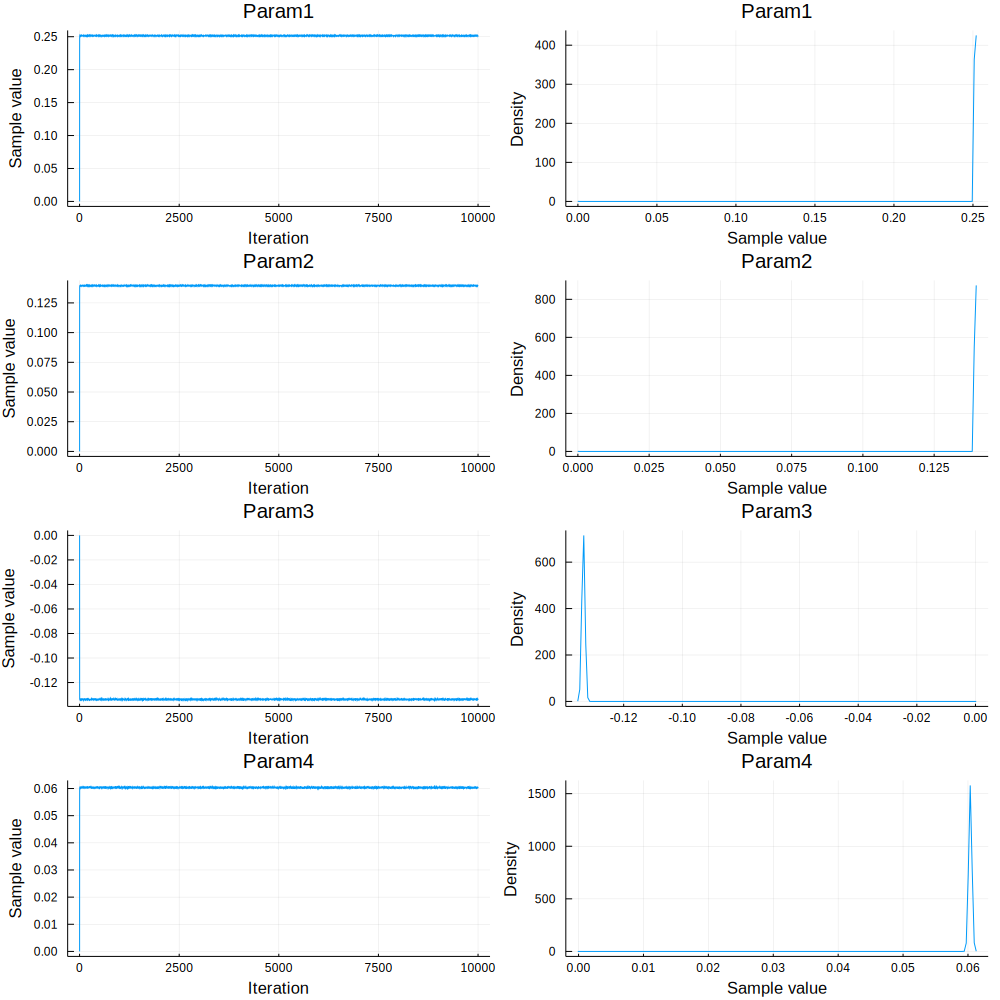

In [22]:
β_pos_sam = Array{Float64, 3}(undef, N_sam + 1, p * q, 1);
β_pos_sam[:, :, 1] = hcat(γ_sam[ind_γ_sam, 1], γ_sam[ind_γ_sam, 2] ,
    γ_sam[ind_γ_sam .+ 1, 1], γ_sam[ind_γ_sam .+ 1, 2]);
β_chain = Chains(β_pos_sam);
pβ = plot(β_chain)

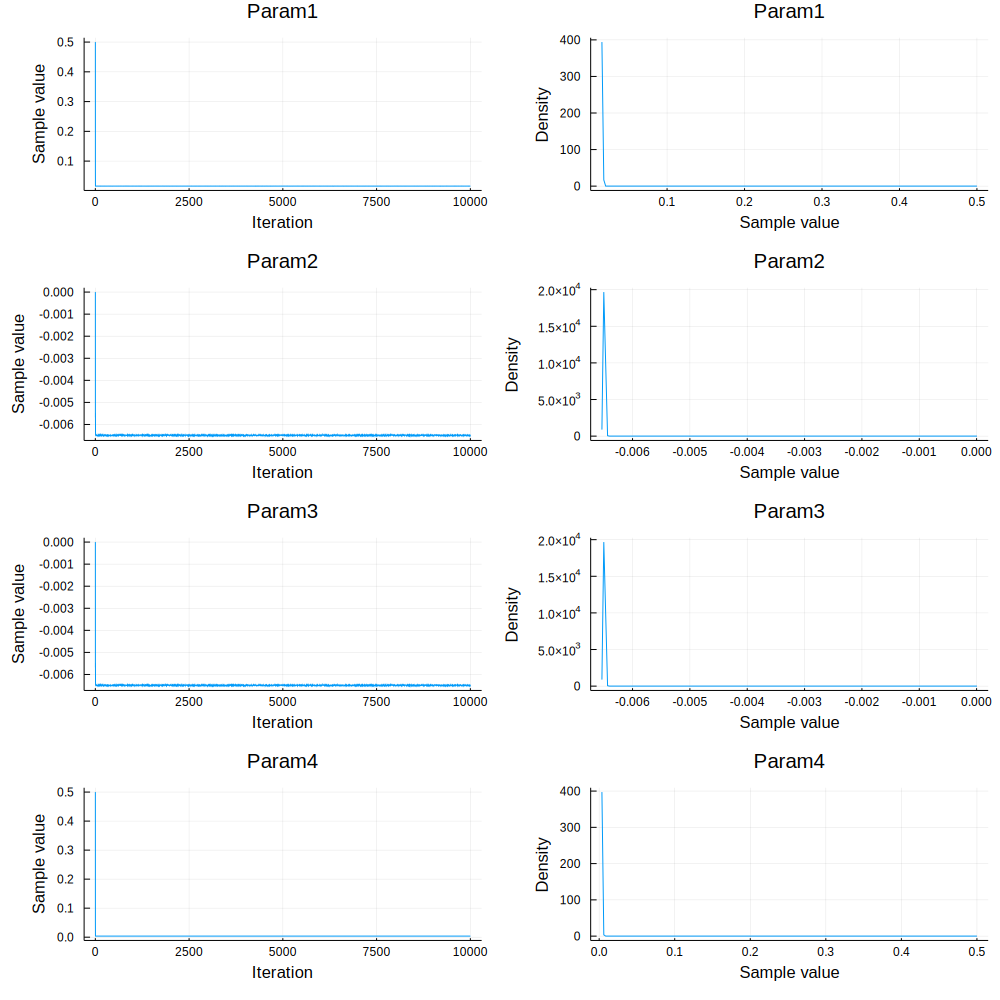

In [23]:
Σ_pos_sam = Array{Float64, 3}(undef, N_sam + 1, q * q, 1);
Σ_pos_sam[:, :, 1] = hcat(Σ_sam[ind_Σ_sam, 1], Σ_sam[ind_Σ_sam, 2], 
    Σ_sam[ind_Σ_sam .+ 1, 1], Σ_sam[ind_Σ_sam .+ 1, 2]);
Σ_chain = Chains(Σ_pos_sam);
pΣ = plot(Σ_chain)

# Posterior Inference 

In [24]:
N_pre_burn = Integer(0.5*N_sam);
half_sample = Integer((N_sam - N_pre_burn)/2)

2500

In [25]:
using RCall 

In [26]:
# ESS-slope #
ESS_slope = fill(0.0, p, q)
MCSE_slope = fill(0.0, p, q)
Rhat_slope = fill(0.0, p, q)
for i in 1:p
    for j in 1:q
        ESS_slope[i, j] = 
            effective_sample_size(γ_sam[ind_γ_sam .+ (i - 1), j][(N_pre_burn + 1):(N_sam + 1)]);
        
        MCMCsample = γ_sam[ind_γ_sam .+ (i - 1), j][(N_pre_burn + 1):(N_sam + 1)];
        
        @rput MCMCsample
        R"""
        library(mcmcse)
        mcse1 = mcse(MCMCsample, size = 50)$se
        """
        @rget mcse1
        
        MCSE_slope[i, j] = mcse1;
        
        #MCSE_slope[i, j] = std(γ_sam[ind_γ_sam .+ (i - 1), j][(N_pre_burn + 1):(N_sam + 1)]) / 
        #    sqrt(ESS_slope[i, j]);
        Rhat_slope[i, j] = potential_scale_reduction(
            γ_sam[ind_γ_sam .+ (i - 1), j][(N_pre_burn + 1):(N_pre_burn + half_sample)], 
            γ_sam[ind_γ_sam .+ (i - 1), j][(N_pre_burn + half_sample + 1):N_sam])
    end
end   
[ESS_slope, MCSE_slope, Rhat_slope]

┌ Warning: RCall.jl: mcmcse: Monte Carlo Standard Errors for MCMC
│ Version 1.4-1 created on 2020-01-29.
│ copyright (c) 2012, James M. Flegal, University of California, Riverside
│                     John Hughes, University of Colorado, Denver
│                     Dootika Vats, University of Warwick
│                     Ning Dai, University of Minnesota
│  For citation information, type citation("mcmcse").
│  Type help("mcmcse-package") to get started.
│ 
└ @ RCall /home/lu/.julia/packages/RCall/g7dhB/src/io.jl:113


3-element Array{Array{Float64,2},1}:
 [4869.459478368496 4888.40434998012; 4752.251951132025 4772.698032410291]               
 [2.0466303107088756e-6 9.407454604781063e-7; 5.975802300723232e-6 2.5870140744027476e-6]
 [1.000137062428341 1.0001826144036974; 1.0000252334684205 1.0000455891095734]           

In [27]:
# ESS-Σ #
ESS_Σ = fill(0.0, q, q)
MCSE_Σ = fill(0.0, q, q)
Rhat_Σ = fill(0.0, q, q)
for i in 1:q
    for j in 1:q
        ESS_Σ[i, j] = 
            effective_sample_size(Σ_sam[ind_Σ_sam .+ (i - 1), j][(N_pre_burn + 1):N_sam]);
        
        MCMCsample = Σ_sam[ind_Σ_sam .+ (i - 1), j][(N_pre_burn + 1):N_sam];
        
        @rput MCMCsample
        R"""
        library(mcmcse)
        mcse1 = mcse(MCMCsample, size = 50)$se
        """
        @rget mcse1
        
        MCSE_Σ[i, j] = mcse1;
        
        #MCSE_Σ[i, j] = std(Σ_sam[ind_Σ_sam .+ (i - 1), j][(N_pre_burn + 1):N_sam]) / sqrt(ESS_Σ[i, j]);
        Rhat_Σ[i, j] = potential_scale_reduction(
            Σ_sam[ind_Σ_sam .+ (i - 1), j][(N_pre_burn + 1):(N_pre_burn + half_sample)], 
            Σ_sam[ind_Σ_sam .+ (i - 1), j][(N_pre_burn + half_sample + 1):N_sam]);
    end
end
[ESS_Σ, MCSE_Σ, Rhat_Σ]

3-element Array{Array{Float64,2},1}:
 [4550.77684238681 4723.683799048054; 4723.683799048054 4528.508115053577]               
 [3.409326703421829e-7 1.5330629163596523e-7; 1.5330629163596523e-7 8.379186205488264e-8]
 [1.0001862759305102 1.0001657102268802; 1.0001657102268802 1.000094224132337]           

In [28]:
summary_table = Array{Float64, 2}(undef, 7, 8);
summary_table[1, :] = vcat(0.0, mean(β_pos_sam[(N_pre_burn + 1):(N_sam + 1), 1, 1]),
    quantile(β_pos_sam[(N_pre_burn + 1):(N_sam + 1), 1, 1], [0.5, 0.025, 0.975]),
    ESS_slope[1, 1], MCSE_slope[1, 1], Rhat_slope[1, 1]);
summary_table[2, :] = vcat(0.0, mean(β_pos_sam[(N_pre_burn + 1):(N_sam + 1), 2, 1]),
    quantile(β_pos_sam[(N_pre_burn + 1):(N_sam + 1), 2, 1], [0.5, 0.025, 0.975]),
    ESS_slope[1, 2], MCSE_slope[1, 2], Rhat_slope[1, 2]);
summary_table[3, :] = vcat(0.0, mean(β_pos_sam[(N_pre_burn + 1):(N_sam + 1), 3, 1]),
    quantile(β_pos_sam[(N_pre_burn + 1):(N_sam + 1), 3, 1], [0.5, 0.025, 0.975]),
    ESS_slope[2, 1], MCSE_slope[2, 1], Rhat_slope[2, 1]);
summary_table[4, :] = vcat(0.0, mean(β_pos_sam[(N_pre_burn + 1):(N_sam + 1), 4, 1]),
    quantile(β_pos_sam[(N_pre_burn + 1):(N_sam + 1), 4, 1], [0.5, 0.025, 0.975]),
    ESS_slope[2, 2], MCSE_slope[2, 2], Rhat_slope[2, 2]);
summary_table[5, :] = vcat(0.0, mean(Σ_sam[ind_Σ_sam, 1][(N_pre_burn + 1):(N_sam + 1)]),
    quantile(Σ_sam[ind_Σ_sam, 1][(N_pre_burn + 1):(N_sam + 1)], [0.5, 0.025, 0.975]),
    ESS_Σ[1, 1], MCSE_Σ[1, 1], Rhat_Σ[1, 1]);
summary_table[6, :] = vcat(0.0, mean(Σ_sam[ind_Σ_sam .+ 1, 1][(N_pre_burn + 1):(N_sam + 1)]),
    quantile(Σ_sam[ind_Σ_sam .+ 1, 1][(N_pre_burn + 1):(N_sam + 1)], [0.5, 0.025, 0.975]),
    ESS_Σ[2, 1], MCSE_Σ[2, 1], Rhat_Σ[2, 1]);
summary_table[7, :] = vcat(0.0, mean(Σ_sam[ind_Σ_sam .+ 1, 2][(N_pre_burn + 1):(N_sam + 1)]),
    quantile(Σ_sam[ind_Σ_sam .+ 1, 2][(N_pre_burn + 1):(N_sam + 1)], [0.5, 0.025, 0.975]),
    ESS_Σ[2, 2], MCSE_Σ[2, 2], Rhat_Σ[2, 2]);
summary_table = round.(summary_table; digits = 6);
rnames = ["β[1, 1]", "β[1, 2]", 
    "β[2, 1]", "β[2, 2]", "Σ[1, 1]", "Σ[1, 2]", "Σ[2, 2]"];
summary_table = [rnames summary_table];
pretty_table(summary_table,  ["" "true" "mean" "median" "2.5%" "97.5%" "ESS" "MCSE" "Rhat"], markdown)

|         | true |      mean |    median |      2.5% |     97.5% |         ESS ⋯
|---------|------|-----------|-----------|-----------|-----------|------------ ⋯
| β[1, 1] |  0.0 |  0.251486 |  0.251489 |  0.251227 |  0.251741 | 4869.459478 ⋯
| β[1, 2] |  0.0 |  0.139497 |  0.139496 |  0.139377 |  0.139622 |  4888.40435 ⋯
| β[2, 1] |  0.0 | -0.133729 |  -0.13373 | -0.134602 | -0.132833 | 4752.251951 ⋯
| β[2, 2] |  0.0 |  0.060349 |   0.06035 |  0.059917 |  0.060755 | 4772.698032 ⋯
| Σ[1, 1] |  0.0 |  0.015986 |  0.015985 |  0.015941 |   0.01603 | 4550.776842 ⋯
| Σ[1, 2] |  0.0 | -0.006491 | -0.006491 | -0.006512 | -0.006471 | 4723.683799 ⋯
| Σ[2, 2] |  0.0 |  0.003656 |  0.003656 |  0.003646 |  0.003667 | 4528.508115 ⋯


In [29]:
pretty_table(summary_table[:, [1, 6, 7, 8]],  ["" "ESS" "MCSE" "Rhat"], markdown)

|         |       ESS |        MCSE |   Rhat |
|---------|-----------|-------------|--------|
| β[1, 1] |  0.251741 | 4869.459478 | 2.0e-6 |
| β[1, 2] |  0.139622 |  4888.40435 | 1.0e-6 |
| β[2, 1] | -0.132833 | 4752.251951 | 6.0e-6 |
| β[2, 2] |  0.060755 | 4772.698032 | 3.0e-6 |
| Σ[1, 1] |   0.01603 | 4550.776842 |    0.0 |
| Σ[1, 2] | -0.006471 | 4723.683799 |    0.0 |
| Σ[2, 2] |  0.003667 | 4528.508115 |    0.0 |


In [30]:
# RMSPE #
MSPE1 = (sum((Y_ord[U_indx, 1] - Y_M_sam_mean[:, 1]).^2) + sum((Y_m1_sam_mean - Y_ord[M1_ind, 1]).^2)) / 
(length(M1_ind) + length(U_indx));
RMSPE1 = sqrt(MSPE1); 
MSPE2 = (sum((Y_ord[U_indx, 2] - Y_M_sam_mean[:, 2]).^2) + sum((Y_m2_sam_mean - Y_ord[M2_ind, 2]).^2)) / 
(length(M2_ind) + length(U_indx))
RMSPE2 = sqrt(MSPE2); 
MSPE = (sum((Y_ord[U_indx, :] - Y_M_sam_mean).^2) + sum((Y_m1_sam_mean - Y_ord[M1_ind, 1]).^2 )
           + sum((Y_m2_sam_mean - Y_ord[M2_ind, 2]).^2)) / (length(M1_ind) + length(M2_ind) + 2 * length(U_indx))
RMSPE = sqrt(MSPE)
round.([RMSPE1 RMSPE2 RMSPE], digits = 4)

1×3 Array{Float64,2}:
 0.074  0.0359  0.0581

In [31]:
# CRPS #

CRPS_m1 = [(sqrt(Y_m1_sam_var[i]) * ( 1 /sqrt(π) - 
        2 * pdf(Normal(), (Y_ord[M1_ind[i], 1] - Y_m1_sam_mean[i]) / sqrt(Y_m1_sam_var[i])) -
        ((Y_ord[M1_ind[i], 1] - Y_m1_sam_mean[i]) / sqrt(Y_m1_sam_var[i])) * 
        (2* cdf(Normal(), (Y_ord[M1_ind[i], 1] - Y_m1_sam_mean[i]) / sqrt(Y_m1_sam_var[i])) - 1 )))
        for i in 1:length(M1_ind)];
CRPS_m2 = [(sqrt(Y_m2_sam_var[i]) * ( 1 /sqrt(π) - 
        2 * pdf(Normal(), (Y_ord[M2_ind[i], 2] - Y_m2_sam_mean[i]) / sqrt(Y_m2_sam_var[i])) -
        ((Y_ord[M2_ind[i], 2] - Y_m2_sam_mean[i]) / sqrt(Y_m2_sam_var[i])) * 
        (2* cdf(Normal(), (Y_ord[M2_ind[i], 2] - Y_m2_sam_mean[i]) / sqrt(Y_m2_sam_var[i])) - 1 )))
        for i in 1:length(M2_ind)];

CRPS_U = [(sqrt(Y_M_sam_var[i, j]) * ( 1 /sqrt(π) - 
        2 * pdf(Normal(), (Y_ord[U_indx[i], j] - Y_M_sam_mean[i, j]) / sqrt(Y_M_sam_var[i, j])) -
        ((Y_ord[U_indx[i], j] - Y_M_sam_mean[i, j]) / sqrt(Y_M_sam_var[i, j])) * 
        (2* cdf(Normal(), (Y_ord[U_indx[i], j] - Y_M_sam_mean[i, j]) / sqrt(Y_M_sam_var[i, j])) - 1)))
        for i in 1:NM, j in 1:q];

CRPS1 = (sum(CRPS_U[:, 1]) + sum(CRPS_m1)) / (length(M1_ind) + NM);
CRPS2 = (sum(CRPS_U[:, 2]) + sum(CRPS_m2)) / (length(M2_ind) + NM);
CRPS = (sum(CRPS_U) + sum(CRPS_m1) + sum(CRPS_m2))/(2 * NM + length(M1_ind) + (length(M2_ind)));
round.([CRPS1 CRPS2 CRPS], digits = 5)

1×3 Array{Float64,2}:
 -0.04135  -0.01988  -0.03061

In [32]:
# CVG #
N_Inf_burn = 1;
count_Y_M = fill(0.0, q);
for j in 1:q
    for i in 1:NM
        count_Y_M[j] = count_Y_M[j] + 
        (((Y_M_sam_mean[i, j] - 1.96 * sqrt(Y_M_sam_var[i, j])) < Y_ord[U_indx[i], j]) && 
            ((Y_M_sam_mean[i, j] + 1.96 * sqrt(Y_M_sam_var[i, j])) > Y_ord[U_indx[i], j]))
    end
end
for i in 1:length(M1_ind)
    count_Y_M[1] = count_Y_M[1] + 
        (((Y_m1_sam_mean[i] - 1.96 * sqrt(Y_m1_sam_var[i])) < Y_ord[M1_ind[i], 1]) && 
         ((Y_m1_sam_mean[i] + 1.96 * sqrt(Y_m1_sam_var[i])) > Y_ord[M1_ind[i], 1]))
end
for i in 1:length(M2_ind)
    count_Y_M[2] = count_Y_M[2] + 
        (((Y_m2_sam_mean[i] - 1.96 * sqrt(Y_m2_sam_var[i])) < Y_ord[M2_ind[i], 2]) && 
         ((Y_m2_sam_mean[i] + 1.96 * sqrt(Y_m2_sam_var[i])) > Y_ord[M2_ind[i], 2]))
end
round.([(count_Y_M[1] / (length(M1_ind) + length(U_indx))) (count_Y_M[2] / 
            (length(M2_ind) + length(U_indx))) (sum(count_Y_M) / (length(M1_ind) + 
                length(M2_ind) + 2 * length(U_indx)))], digits = 4)

1×3 Array{Float64,2}:
 0.9563  0.9579  0.9571

In [34]:
# INT #
INT_m1 = [((2 * 1.96 * sqrt(Y_m1_sam_var[i])) + 
                (2 / 0.05)*(Y_m1_sam_mean[i] - 1.96 * sqrt(Y_m1_sam_var[i]) - Y_ord[M1_ind[i], 1]) * 
                (Y_ord[M1_ind[i], 1] < (Y_m1_sam_mean[i] - 1.96 * sqrt(Y_m1_sam_var[i]))) + 
                (2 / 0.05)*(Y_ord[M1_ind[i], 1] - Y_m1_sam_mean[i] - 1.96 * sqrt(Y_m1_sam_var[i])) * 
                (Y_ord[M1_ind[i], 1] > (Y_m1_sam_mean[i] + 
                1.96 * sqrt(Y_m1_sam_var[i])))) for i in 1:length(M1_ind)]

INT_m2 = [((2 * 1.96 * sqrt(Y_m2_sam_var[i])) + 
                (2 / 0.05)*(Y_m2_sam_mean[i] - 1.96 * sqrt(Y_m2_sam_var[i]) - Y_ord[M2_ind[i], 2]) * 
                (Y_ord[M2_ind[i], 2] < (Y_m2_sam_mean[i] - 1.96 * sqrt(Y_m2_sam_var[i]))) + 
                (2 / 0.05)*(Y_ord[M2_ind[i], 2] - Y_m2_sam_mean[i] - 1.96 * sqrt(Y_m2_sam_var[i])) * 
                (Y_ord[M2_ind[i], 2] > (Y_m2_sam_mean[i] + 
                1.96 * sqrt(Y_m2_sam_var[i])))) for i in 1:length(M2_ind)]

INT_U = [((2 * 1.96 * sqrt(Y_M_sam_var[i, j])) + 
                (2 / 0.05)*(Y_M_sam_mean[i, j] - 1.96 * sqrt(Y_M_sam_var[i]) - Y_ord[U_indx[i], j]) * 
                (Y_ord[U_indx[i], j] < (Y_M_sam_mean[i, j] - 1.96 * sqrt(Y_M_sam_var[i, j]))) + 
                (2 / 0.05)*(Y_ord[U_indx[i], j] - Y_M_sam_mean[i, j] - 1.96 * sqrt(Y_M_sam_var[i, j])) * 
                (Y_ord[U_indx[i], j] > (Y_M_sam_mean[i, j] + 
                1.96 * sqrt(Y_M_sam_var[i, j])))) for i in 1:NM, j in 1:q]

INT1 = (sum(INT_U[:, 1]) + sum(INT_m1)) / (length(M1_ind) + NM);
INT2 = (sum(INT_U[:, 2]) + sum(INT_m2)) / (length(M2_ind) + NM);
INT = (sum(INT_U) + sum(INT_m1) + sum(INT_m2))/(2 * NM + length(M1_ind) + (length(M2_ind)));

round.([INT1 INT2 INT], digits = 5)

1×3 Array{Float64,2}:
 0.34675  0.17105  0.25891